# Wikipedia Traffic Forecasting
## A starting kit
**V. Croft, Y. Haddad**

This is a very short kernel aiming to help on getting hands into time series analysis and forecasting. We will be using data from the [Wikipedia Traffic Forecasting challange](https://www.kaggle.com/c/web-traffic-time-series-forecasting) on Kaggle.

This example is based on these kernels:
* https://www.kaggle.com/muonneutrino/wikipedia-traffic-data-exploration
* https://www.kaggle.com/screech/ensemble-of-arima-and-lstm-model-for-wiki-pages


You can find this example as Kernel in Kaggle platform ([https://www.kaggle.com/yhaddad/forecasting-starting-kit-geneva-kaggle-dojo/](https://www.kaggle.com/yhaddad/forecasting-starting-kit-geneva-kaggle-dojo/)).

In [1]:
# Some basic libraries 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
%matplotlib inline

In [3]:
import shared_functions as sf

In [4]:
from imp import reload

## Loading data

In [5]:
df_train = pd.read_csv('./input/train_1.csv').fillna(0)
df_train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


## Feature Engineering

### Language information

We might reasonably assume different languages used in Wikipedia might affect the dataset. A simple regular expression can be used to search for the language code in the wikipedia URL. There are also a number of non-wikipedia URLs that will fail the regex search. These are wikimedia pages, so we give them the code 'na' since we can't determine their language. Many of these will be things like images that do not really have a language.

In [8]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res.group(0)[0:2]
    return 'na'

In [9]:
df_train['lang'] = df_train.Page.map(get_language)

In [10]:
df_train[df_train.Page == 'Noël_fr.wikipedia.org_all-access_all-agents']

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,lang
26932,Noël_fr.wikipedia.org_all-access_all-agents,236.0,260.0,237.0,192.0,229.0,267.0,272.0,251.0,232.0,...,20190.0,42688.0,32272.0,11737.0,5907.0,4259.0,3536.0,3081.0,3341.0,fr


There are 7 languages plus the media pages. The languages used here are: English, Japanese, German, French, Chinese, Russian, and Spanish. This will make any analysis of the URLs difficult since there are four different writing systems to be dealt with (Latin, Cyrillic, Chinese, and Japanese). 

First, let's create dataframes for the different types of entries and calculate the sum of all views.

In [11]:
lang_sets = {}
lang_sets['en'] = df_train[df_train.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = df_train[df_train.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = df_train[df_train.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = df_train[df_train.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = df_train[df_train.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = df_train[df_train.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = df_train[df_train.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = df_train[df_train.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

and visualise

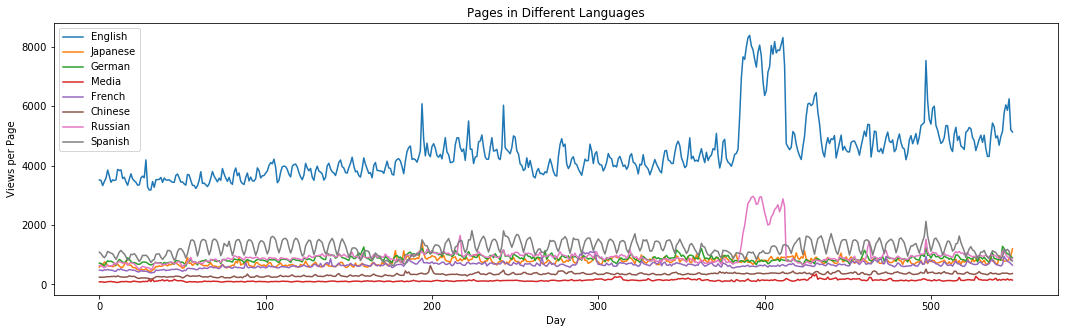

In [12]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[18,5])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()

Alternatively, using interactive graphic library plotly

In [15]:
reload(sf)

<module 'shared_functions' from '/Users/Boris/Desktop/geneva-data-science/using_my_rep/KaggleDojoTimeSeriesForcasting/shared_functions.py'>

In [16]:
list_series = [x for x in sums.values()]
sf.make_plotly_graph(list_series, ['en', 'ja', 'ge', 'na', 'fr', 'zh', 'ru', 'sp'] ,'')

### Looking at Periodic Structure with FFTs

All solutions for time series forecasting are highly dependent on the length of the sequences in question. Some work very well for short sequences, up to 100-300 items but will forget information from older items on longer sequences. Competition timeseries is up to 700 days long, so it might be necessary to find some method to "strengthen" GRU memory.

Looking at the Fast Fourier Transform (FFT) shows us the strongest frequencies in the periodic signal and can give a first estimate as to the length of some of the sequences.

In [ ]:
from scipy.fftpack import fft
def plot_with_fft(key):
    f, ax = plt.subplots(2, figsize=(18,8))
    ax[0].set_ylabel('Views per Page')
    ax[0].set_xlabel('Day')
    ax[0].set_title(labels[key])
    ax[0].plot(days,sums[key],label = labels[key] )

    fft_complex = fft(sums[key])
    fft_mag = [np.sqrt(np.real(x)*np.real(x)+np.imag(x)*np.imag(x)) for x in fft_complex]
    fft_xvals = [day / float(days[-1]) for day in days]
    npts = len(fft_xvals) // 2 + 1
    fft_mag = fft_mag[:npts]
    fft_xvals = fft_xvals[:npts]
        
    ax[1].set_ylabel('FFT Magnitude')
    ax[1].set_xlabel(r"Frequency [days]$^{-1}$")
    ax[1].set_title('Fourier Transform')
    ax[1].plot(fft_xvals[1:],fft_mag[1:],label = labels[key] )
    ax[1].axvline(x=1./7,color='red',alpha=0.3)
    ax[1].axvline(x=2./7,color='red',alpha=0.3)
    ax[1].axvline(x=3./7,color='red',alpha=0.3)

    plt.show()

for key in sums:
    plot_with_fft(key)

# Individual Entry Data

In [ ]:
def plot_entry(key,idx, ax):
    data = lang_sets[key].iloc[idx,1:]
    ax.plot(days,data, label=df_train.iloc[lang_sets[key].index[idx],0])
    ax.set_xlabel('day')
    ax.set_ylabel('views')

In [ ]:
f, ax = plt.subplots(figsize=(18,4))
plot_entry(key='en', idx=4, ax=ax )
plot_entry(key='en', idx=5, ax=ax )
plot_entry(key='en', idx=6, ax=ax )
plot_entry(key='en', idx=7, ax=ax )
plot_entry(key='en', idx=8, ax=ax )
ax.legend()

Nothing special about those pages as I selected them randomly. The only purpose is that you can explore individual entries, one by one, and see if there is any correlation with social event, holiday, or a movie release. 

As a small exercise, to to find the christmas page in French ;) 

## Base prediction
Many methods and tools can be used for time series forecasting. 
examples: RNN, autoencoders, Kernel methods, autoregressive integrated moving average models.

For simplicity and to provide baseline model, we will only focus on two methods, the traditional autoregressive integrated moving average model and Recurrent Neural Network RNN. The later became is the trending method for prediction, will try to make a simple Keras model using LSTM cells.

### Buidling an ARIMA forcasting model

In [ ]:
npages = 5
top_pages = {}
for key in lang_sets:
    print(key)
    sum_set = pd.DataFrame(lang_sets[key][['Page']])
    sum_set['total'] = lang_sets[key].sum(axis=1)
    sum_set = sum_set.sort_values('total',ascending=False)
    print(sum_set.head(10))
    top_pages[key] = sum_set.index[0]
    print('\n\n')

In [ ]:
from statsmodels.tsa.arima_model import ARIMA 

In [ ]:
import warnings

cols = df_train.columns[1:-1]
for key in top_pages:
    data = np.array(df_train.loc[top_pages[key],cols],'f')
    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(data,[2,1,4])
            result = arima.fit(disp=False)
        except:
            try:
                arima = ARIMA(data,[2,1,2])
                result = arima.fit(disp=False)
            except:
                print(df_train.loc[top_pages[key],'Page'])
                print('\tARIMA failed')
    #print(result.params)
    pred = result.predict(2,599,typ='levels')
    x = [i for i in range(600)]
    i=0
    
    f, ax = plt.subplots(figsize=(18,4))
    ax.plot(x[2:len(data)],data[2:] ,label='Data')
    ax.plot(x[2:],pred,label='ARIMA Model')
    print str(df_train.loc[top_pages[key],'Page'])
    ax.set_title(str(df_train.loc[top_pages[key],'Page']).decode('utf-8'))
    ax.set_xlabel('Days')
    ax.set_ylabel('Views')
    ax.legend()
    plt.show()

### Buidling an LSTM model using Keras

in this part you need Keras installed. Instruction can be found on [keras.io](keras.io).
In this section will try to train an LSTM models for top pages of all the languages for demonstration. We will, therefore, drop the `Page` column from the dataframe.

In [ ]:
df_train = df_train.drop('Page',axis = 1)
df_train.head()

In [ ]:
#Packages for pre processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

 # Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
def keras_regressor():
    regressor = Sequential()
    # Adding the input layerand the LSTM layer
    regressor.add(LSTM(units = 8, activation = 'relu', input_shape = (None, 1)))
    # Adding the output layer
    regressor.add(Dense(units = 1))
    # Compiling the RNN
    regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
    return regressor

for key in sums:
    f, ax = plt.subplots(figsize=(18,4))
    
    row = [0]*sums[key].shape[0]
    for i in range(sums[key].shape[0]):
        row[i] = sums[key][i]

    #Using Data From Random Row for Training and Testing
    X = row[0:549]
    y = row[1:550]
    
    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
    
    # Feature Scaling
    sc = MinMaxScaler()
    X_train = np.reshape(X_train,(-1,1))
    y_train = np.reshape(y_train,(-1,1))
    X_train = sc.fit_transform(X_train)
    y_train = sc.fit_transform(y_train)
    #Reshaping Array
    X_train = np.reshape(X_train, (384,1,1))

    # Initialising the RNN
    regressor = keras_regressor()

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, batch_size = 10, epochs = 100, verbose = 0)

    # Getting the predicted Web View
    inputs = X
    inputs = np.reshape(inputs,(-1,1))
    inputs = sc.transform(inputs)
    inputs = np.reshape(inputs, (549,1,1))
    y_pred = regressor.predict(inputs)
    y_pred = sc.inverse_transform(y_pred)

    print(key)
    #Visualising Result
    ax.plot(y, color = 'red', label = 'Real Web View')
    ax.plot(y_pred, color = 'blue', label = 'Predicted Web View')
    ax.set_title ('Web View Forecasting: %s' % key)
    ax.set_xlabel('Number of Days from Start')
    ax.set_ylabel('Web View')
    ax.legend()
    plt.show()

## Make submission

The models above are very simple ones and need to be optimised. You could, therefore, consider a further features engineering and hyperparameters optimisation for the proposed models. You can also use other frameworks to build your forecasting models. Few examples are `pytorch`, `tensorflow`, `sklearn` ...etc. 

The last step will be to ma e a submission, and for that, you can refer to the documentation on Kaggle platform to make a submission.